In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.backend as K

In [2]:
class RetinalClassifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def data_ingestion(self, train_dir, test_dir):
        """Initialize data generators with preprocessing"""
        self.train_datagen = ImageDataGenerator(
            preprocessing_function=self.preprocess_image,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            validation_split=0.2,
            rescale=None
        )
        
        self.test_datagen = ImageDataGenerator(
            preprocessing_function=self.preprocess_image,
            rescale=None
        )
        
        self.train_generator = self.train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='training',
            color_mode='rgb'
        )
        
        self.valid_generator = self.train_datagen.flow_from_directory(
            train_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            subset='validation',
            color_mode='rgb'
        )
        
        self.test_generator = self.test_datagen.flow_from_directory(
            test_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            color_mode='rgb'
        )
        
        return self.train_generator, self.valid_generator, self.test_generator

    def preprocess_image(self, image):
        """Apply preprocessing steps to a single image"""
        # Convert image to uint8 if needed
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)

        # Ensure correct channel ordering
        if len(image.shape) == 3:
            if image.shape[2] == 4:  # Handle RGBA
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            green = image[:, :, 1]
        else:
            green = image

        # Convert to uint8 and ensure correct range
        green = cv2.normalize(green, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        clahe_output = clahe.apply(green)

        # Vessel enhancement
        vessels = self._frangi_filter(clahe_output)

        # Final enhancement
        enhanced = cv2.addWeighted(clahe_output, 0.7, vessels, 0.3, 0)
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

        return enhanced_rgb / 255.0

    def _frangi_filter(self, image):
        """Apply Frangi filter for vessel enhancement"""
        from skimage.filters import frangi
        vessels = frangi(
            image.astype(float),
            sigmas=range(1, 10, 2),
            black_ridges=False
        )
        return ((vessels - vessels.min()) / (vessels.max() - vessels.min()) * 255).astype(np.uint8)

    def visualize_preprocessing_steps(self, image):
        """Visualize all preprocessing steps"""
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
            
        # Store intermediate results
        results = {
            'Original': image,
            'Green Channel': image[:, :, 1] if len(image.shape) == 3 else image,
        }
        
        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        results['CLAHE'] = clahe.apply(results['Green Channel'])
        
        # Vessels
        results['Vessels'] = self._frangi_filter(results['CLAHE'])
        
        # Enhanced
        results['Enhanced'] = cv2.addWeighted(
            results['CLAHE'], 0.7,
            results['Vessels'], 0.3,
            0
        )
        
        # Visualization
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        for ax, (title, img) in zip(axes, results.items()):
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def build_model(self):
        """Build VGG16 model with custom top layers"""
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        predictions = Dense(1, activation='sigmoid')(x)
        
        self.model = Model(inputs=base_model.input, outputs=predictions)
        
        # Freeze base layers
        for layer in base_model.layers:
            layer.trainable = False
            
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model

    def train_model(self, epochs=10):
        """Train the model"""
        self.history = self.model.fit(
            self.train_generator,
            validation_data=self.valid_generator,
            epochs=epochs
        )
        return self.history

    def evaluate_model(self):
        """Evaluate model and print metrics"""
        # Generate predictions
        y_pred = self.model.predict(self.test_generator)
        y_pred_classes = (y_pred > 0.5).astype(int)
        y_true = self.test_generator.classes
        
        # Calculate metrics
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred_classes))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            confusion_matrix(y_true, y_pred_classes),
            annot=True,
            fmt='d',
            cmap='Blues'
        )
        plt.title('Confusion Matrix')
        plt.show()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    def generate_gradcam(self, image, layer_name='block5_conv3'):
        """Generate Grad-CAM heatmap for a single image"""
        img_array = np.expand_dims(self.preprocess_image(image), axis=0)
        
        grad_model = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(layer_name).output, self.model.output]
        )
        
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, 0]
            
        # Extract gradients
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        
        # Generate heatmap
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        
        # Superimpose heatmap on original image
        heatmap = cv2.resize(heatmap[0], (image.shape[1], image.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        superimposed = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(superimposed)
        plt.title('Grad-CAM')
        plt.axis('off')
        plt.show()

    def try_prediction(self, image_path):
        """
        Make prediction for a single image and visualize results
        
        Args:
            image_path (str): Path to the image file
            
        Returns:
            dict: Prediction results including probability and class
        """
        try:
            # Load and preprocess image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
                
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize image
            image = cv2.resize(image, self.img_size)
            
            # Process image and make prediction
            processed = self.preprocess_image(image)
            prediction = self.model.predict(np.expand_dims(processed, axis=0), verbose=0)[0][0]
            
            # Create results dictionary
            results = {
                'probability': prediction,
                'class': 'Abnormal' if prediction > 0.5 else 'Normal',
                'threshold': 0.5
            }
            
            # Print results
            print("\nPrediction Results:")
            print("-" * 20)
            print(f"Probability: {results['probability']:.3f}")
            print(f"Class: {results['class']}")
            print(f"Threshold: {results['threshold']}")
            
            # Create figure with subplots
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(131)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')
            
            # Preprocessed image
            plt.subplot(132)
            plt.imshow(processed)
            plt.title('Preprocessed Image')
            plt.axis('off')
            
            # GradCAM visualization
            plt.subplot(133)
            self.generate_gradcam(image)
            plt.title('GradCAM Heatmap')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Show detailed preprocessing steps
            print("\nPreprocessing Steps Visualization:")
            self.visualize_preprocessing_steps(image)
            
            return results
            
        except Exception as e:
            print(f"Error during prediction: {str(e)}")
            raise
        
    def visualize_batch_predictions(self, image_paths, num_samples=5):
        """
        Visualize predictions for multiple images
        
        Args:
            image_paths (list): List of paths to image files
            num_samples (int): Number of samples to visualize
        """
        # Sample random images if more than num_samples
        if len(image_paths) > num_samples:
            image_paths = np.random.choice(image_paths, num_samples, replace=False)
        
        results = []
        for path in image_paths:
            try:
                result = self.try_prediction(path)
                results.append({
                    'path': path,
                    **result
                })
            except Exception as e:
                print(f"Failed to process {path}: {str(e)}")
                continue
        
        # Create summary table
        summary_df = pd.DataFrame(results)
        print("\nBatch Prediction Summary:")
        print(summary_df)
        
        return summary_df

In [3]:
train_dir = Path('../artifacts/dataset/train')
test_dir = Path('../artifacts/dataset/test')
img_sample_dir_0 = Path('../artifacts/dataset/test/0/IM5005EY.JPG')
img_sample_dir_1 = Path('../artifacts/dataset/test/1/032_01.1.060-1.02_L-06.JPG')

In [4]:
# Initialize classifier
classifier = RetinalClassifier()

# Load and preprocess data
train_gen, valid_gen, test_gen = classifier.data_ingestion(train_dir, test_dir)

Found 671 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [5]:
# Build and train model
model = classifier.build_model()
history = classifier.train_model(epochs=2)

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5608 - loss: 0.7304 

c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 291s 14s/step - accuracy: 0.5612 - loss: 0.7306 - val_accuracy: 0.5269 - val_loss: 0.6976
Epoch 2/2
21/21 ━━━━━━━━━━━━━━━━━━━━ 277s 13s/step - accuracy: 0.6676 - loss: 0.6442 - val_accuracy: 0.4431 - val_loss: 0.7046


9/9 ━━━━━━━━━━━━━━━━━━━━ 93s 10s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.09      0.15       132
           1       0.53      0.91      0.67       148

    accuracy                           0.52       280
   macro avg       0.49      0.50      0.41       280
weighted avg       0.50      0.52      0.42       280



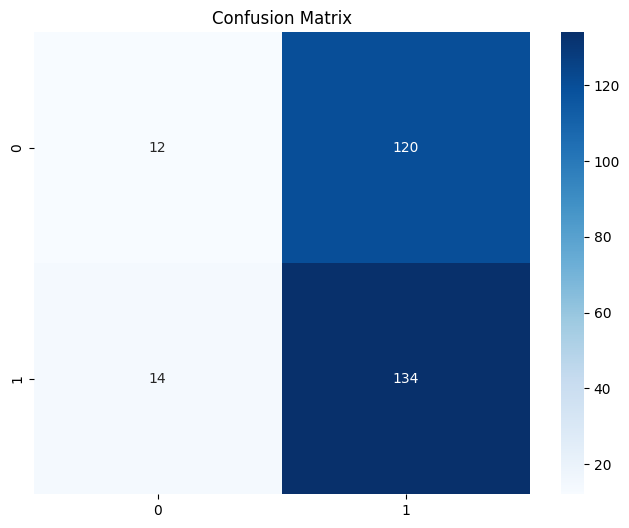

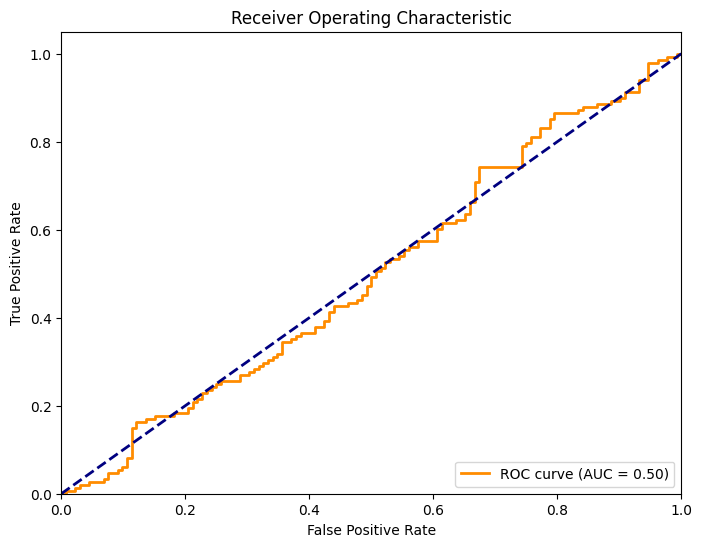

In [6]:
# Evaluate and visualize results
classifier.evaluate_model()


Prediction Results:
--------------------
Probability: 0.524
Class: Abnormal
Threshold: 0.5


c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


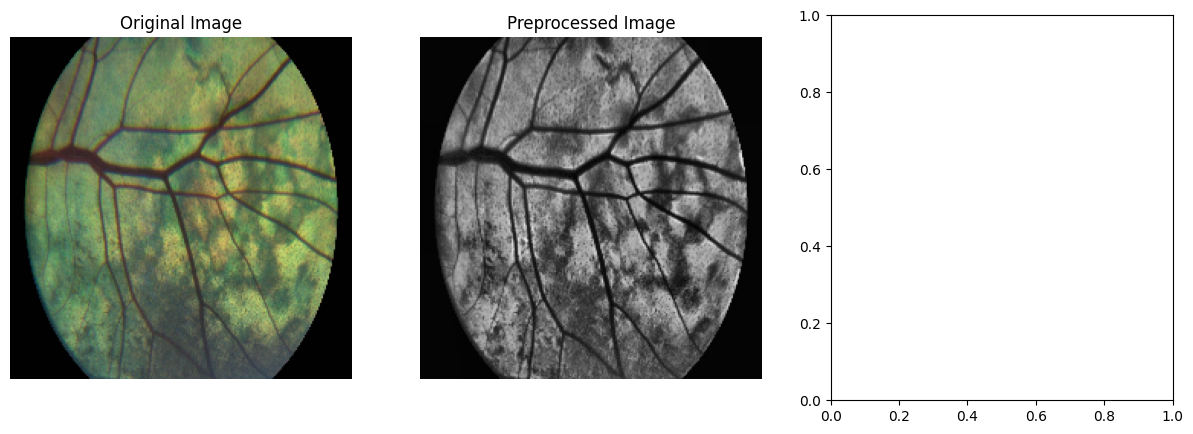

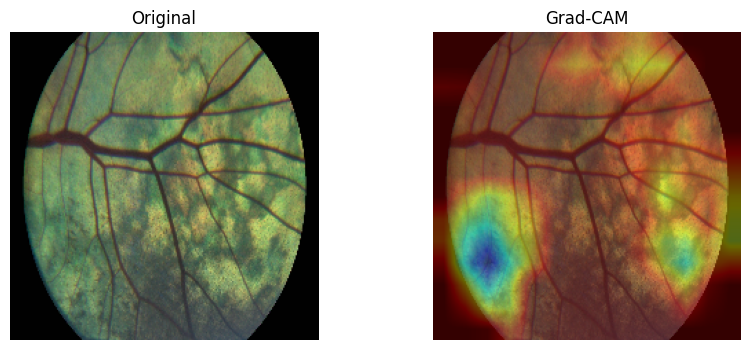

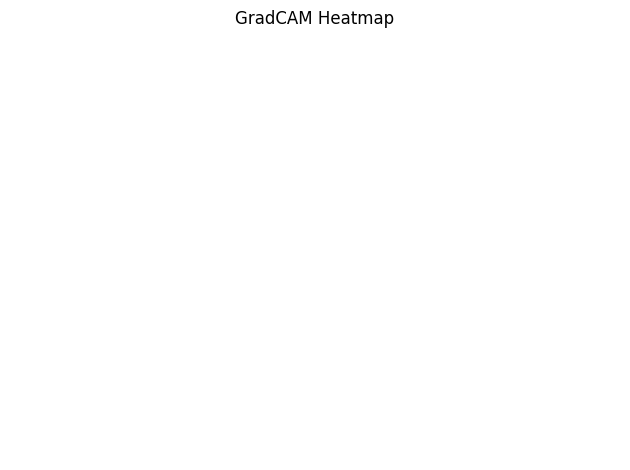


Preprocessing Steps Visualization:


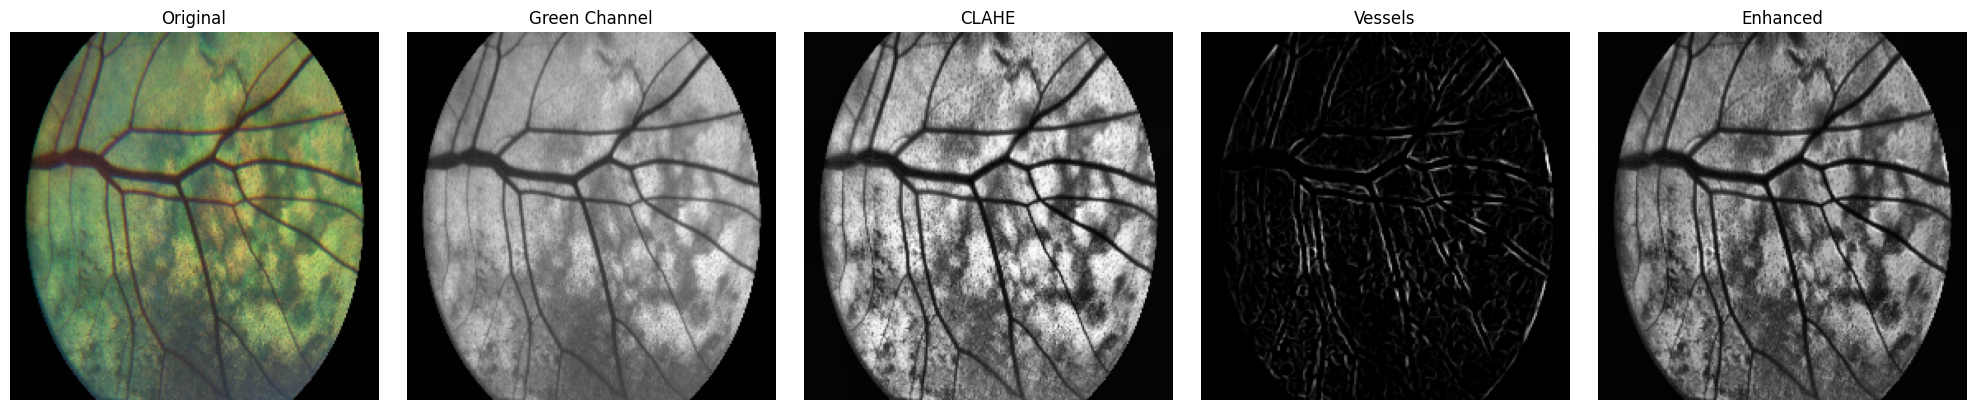


Prediction Results:
--------------------
Probability: 0.497
Class: Normal
Threshold: 0.5


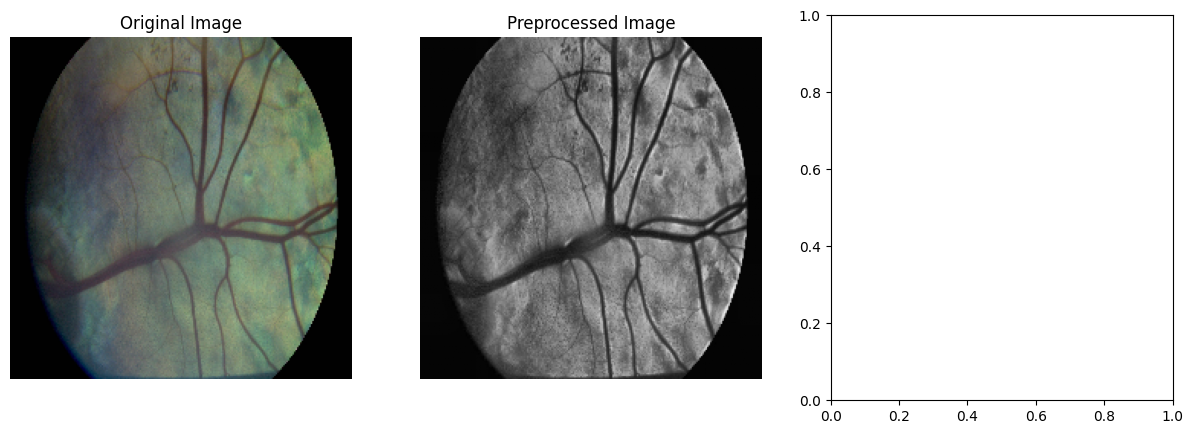

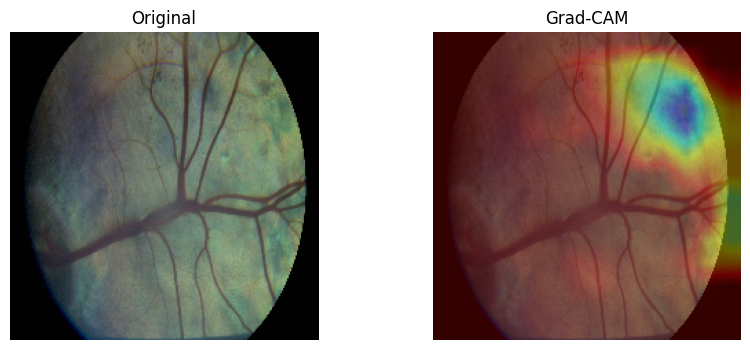

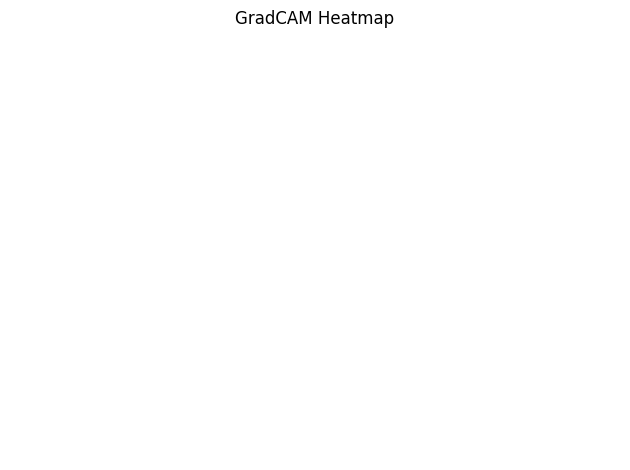


Preprocessing Steps Visualization:


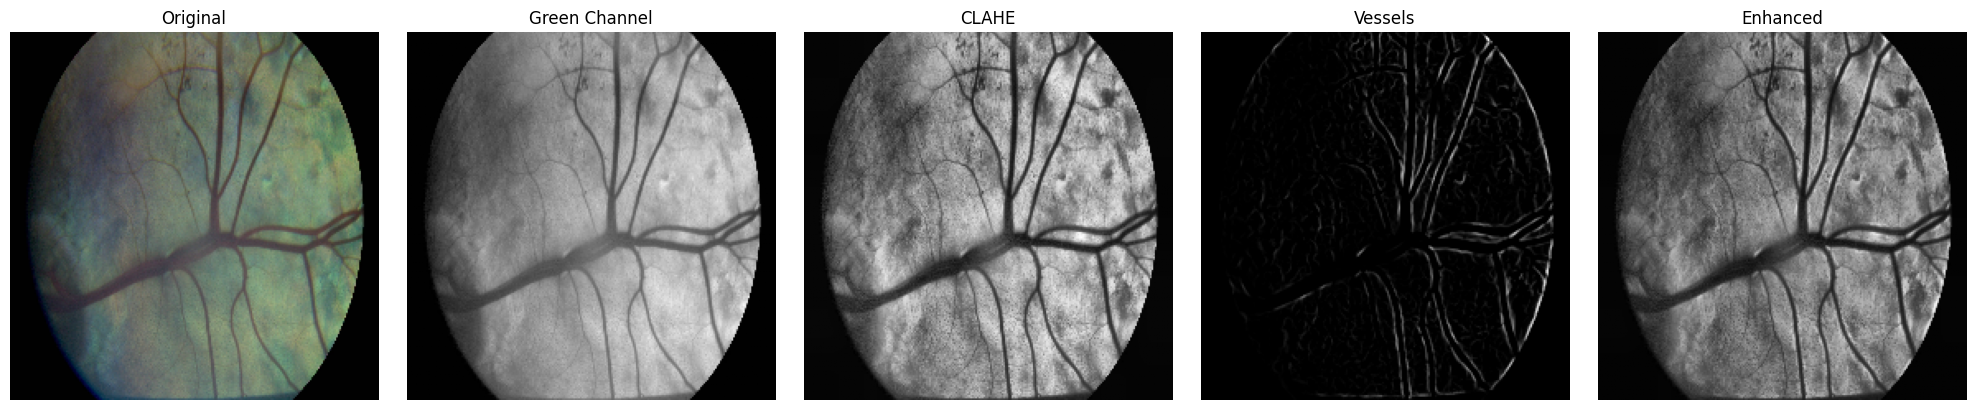


Batch Prediction Summary:
                                                path  probability     class  \
0           ..\artifacts\dataset\test\0\IM5005EY.JPG     0.524182  Abnormal   
1  ..\artifacts\dataset\test\1\032_01.1.060-1.02_...     0.496553    Normal   

   threshold  
0        0.5  
1        0.5  


In [8]:
# Single image prediction
# result = classifier.try_prediction(img_sample_dir_0)

# Batch prediction
image_paths = [img_sample_dir_0, img_sample_dir_1]
summary = classifier.visualize_batch_predictions(image_paths, num_samples=2)